In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools
using Random

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [3]:
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [4]:
truth = (σy = 0.6, σang = 0.3, xw = 2)
n = 10^3

1000

In [5]:
data = (y0 = rand(Normal(0.0, truth.σy), n), ang = rand(Normal(0.0, truth.σang), n),);

In [6]:
pred(x, waist, y, ang) = y .+ ang .* (x-waist)

pred (generic function with 1 method)

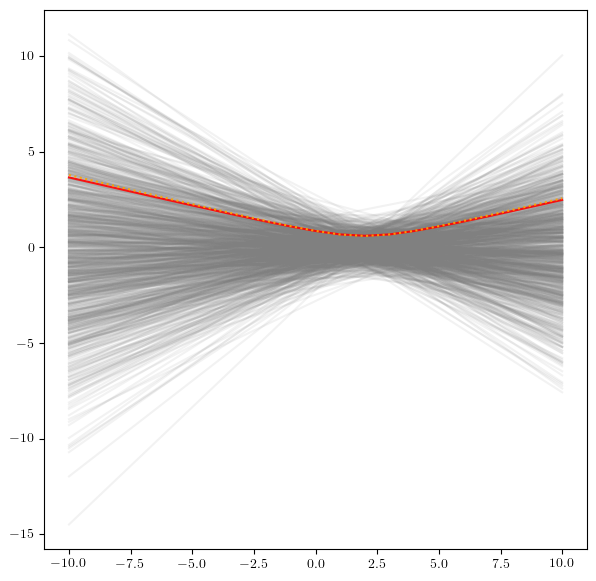

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f96258bc520>

In [7]:
x = -10:10
y = [pred(x_r, truth.xw, data.y0, data.ang) for x_r in x]
y_std = [std(y_tmp) for y_tmp in y]

truth_env = sqrt.(truth.σy^2 .+ truth.σang.^2 .* (x .- truth.xw).^2 )

fig, ax= plt.subplots(1,1, figsize=(7,7))

for i in 1:n
    y_run = [y_tmp[i] for y_tmp in y]
    ax.plot(x, y_run, color="gray", alpha=0.1)
end

ax.plot(x, truth_env, color="red", alpha=0.9)
ax.plot(x, y_std, color="orange", alpha=0.9, ls=":")


In [8]:
fit_data = (x = [x[i] for i in [1,7,14,20]], y = [fit(Histogram, y[i], nbins=20) for i in [1,7,14,20]]);

In [9]:
function log_lik(; data = fit_data)
    
    return params -> begin   
        
        ll = 0.0
        σ_vect = sqrt.(params.σy^2 .+ params.σang.^2 .* (data.x .- params.xw).^2 )
        
        for i in 1:4
            y_pred = params.I[i] * pdf.(Normal.(params.μ[i], σ_vect[i]), midpoints(data.y[i].edges[1]))
            ll += sum(logpdf.(Normal.(y_pred, params.fluct[i]), data.y[i].weights ))
        end
        
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

#47 (generic function with 1 method)

In [10]:
prior_ang = NamedTupleDist(
    μ = [-5 .. 5, -5 .. 5, -5 .. 5, -5 .. 5],
    fluct = [0 .. 10^3, 0 .. 10^3, 0 .. 10^3, 0 .. 10^3],
    I = [0 .. 10^4 for i in 1:4],
    σy = 0 .. 2,
    σang = 0 .. 2,
    xw = -5 .. 5,
);

In [11]:
par_tmp = rand(prior_ang)

(μ = [-1.4858215424097354, 0.5702295205825836, -2.7995983899573385, -4.296371287791041], fluct = [272.6213782186535, 536.2657163544045, 412.15505510232896, 585.953116821051], I = [7587.398192411026, 3279.6318976188177, 6316.0620801917485, 5831.115777929674], σy = 0.2720654426438709, σang = 0.03645519686282128, xw = 3.371977089271743)

In [12]:
log_likelihood(par_tmp)

LogDVal{Float64}(-609.9164935750221)

In [13]:
iter = 8000
iter_warmup = 500
chains = 4;

In [14]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [15]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [16]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)
hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor); #HamiltonianMC

In [17]:
@time samples_is = bat_sample(posterior_is, MCMCSampling(nsteps = iter, mcalg = hmc_sampler, nchains = chains, strict=false));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm PriorSubstitution()
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 4 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 4 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 4 tuned, 0 

161.427992 seconds (447.81 M allocations: 159.839 GiB, 35.88% gc time, 0.01% compilation time)


In [18]:
samples = samples_is.result;

In [19]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [20]:
sz = size(flatview(unshaped.(samples.v)))

(15, 15942)

In [21]:
param_mode = mode(samples)

ShapedAsNT((μ = [0.008964725998560574, -0.015470035682612071, 0.0002881980478450785, -0.0651137720225945], fluct = [4.142076940048653, 5.307101715523436, 5.5936708727651245, 4.541689519919375], I = [1958.884094377531, 983.448660173507, 198.49226967621487, 1001.2717316877337], σy = 0.5702894164405307, σang = 0.30223089208009846, xw = 1.7989300301592026))

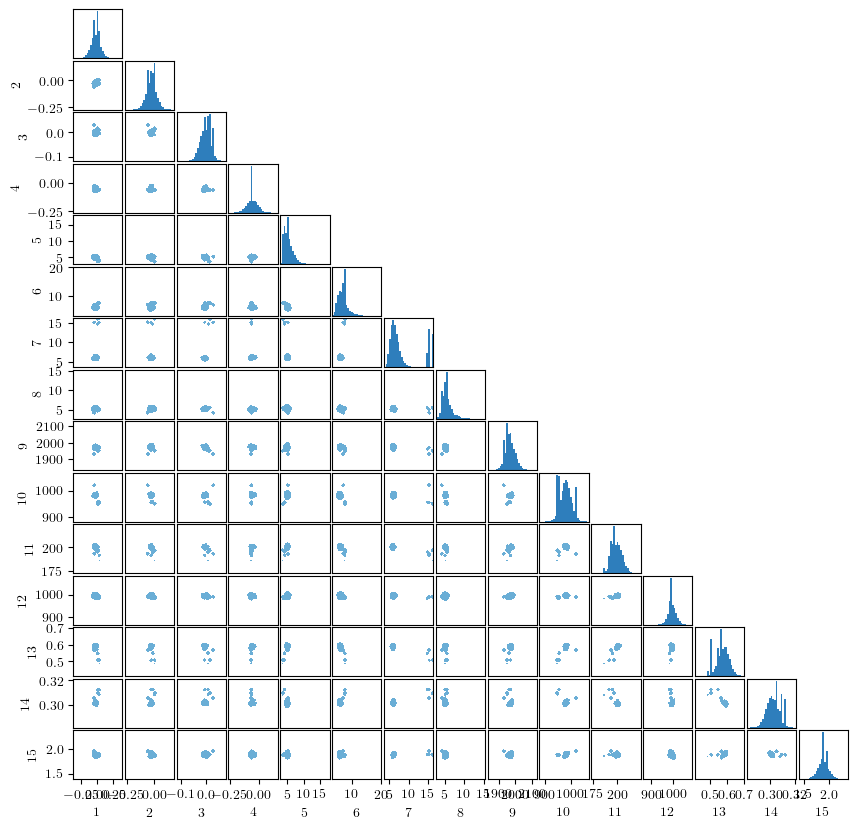

In [22]:
dims = 1:15
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

## Plot of the Crossection: 

In [23]:
pred(s, sw, sigma, sigma_ang) = sigma .+ sigma_ang .* (s-sw)*1000

pred (generic function with 1 method)

In [24]:
truth = (σ = 0.2, σp = 4.0*10^-5, sw = 2.774)

n = 10^3
s = range(0.0, stop=25,length=50)

data = (σx = rand(Normal(0.0, truth.σ), n), σy = rand(Normal(0.0, truth.σ), n), σpx = rand(Normal(0.0, truth.σp), n), σpy = rand(Normal(0.0, truth.σp), n));

x = [pred(sr, truth.sw, data.σx, data.σpx) for sr in s]
y = [pred(sr, truth.sw, data.σy, data.σpy) for sr in s];

y_std = [std(y_tmp) for y_tmp in y]
x_std = [std(x_tmp) for x_tmp in x]

r_std = sqrt.(y_std.^2 .+ x_std.^2)

x = hcat(x...)
y = hcat(y...);

In [25]:
theta = range(0, stop = 2*pi, length=15)
    
theta_grid = ones(length(s)) * theta'
zgrid = s * ones(length(theta))'

truth_env = sqrt(2)*sqrt.(truth.σ^2 .+ 10^6*truth.σp.^2 .* (s .- truth.sw).^2)

xgrid = truth_env .* cos.(theta_grid) .+ 0.0
ygrid = truth_env .* sin.(theta_grid) .+ 0.0;

xgrid_approx = r_std .* cos.(theta_grid) .+ 0.0
ygrid_approx = r_std .* sin.(theta_grid) .+ 0.0;

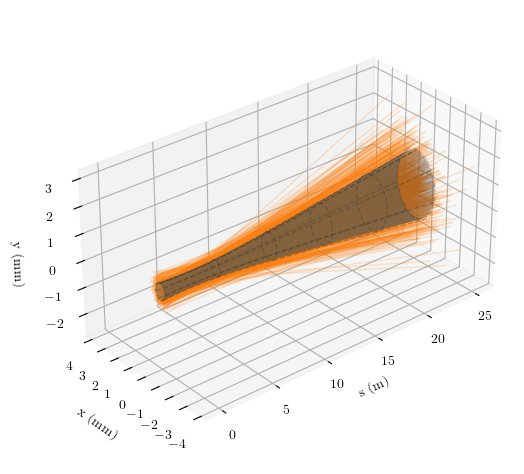

In [87]:
fig = plt.figure(figsize=(5.905631659056317, 5.905631659056317))
ax = fig.add_subplot(111, projection="3d")

for i in 1:n
    ax.plot(s, x[i,:], y[i,:],
        lw=1.0,
        color="C1",  # charge_norm[i] pol_ang_log
        "-", 
        alpha=0.2, 
    )  
end

ax.plot_surface(zgrid, ygrid, xgrid, alpha=0.3, color="C0")

ax.plot_wireframe(zgrid, ygrid_approx, xgrid_approx, alpha=0.2, color="black", rstride=10, cstride=2, linestyles="dashed", lw=1)

ax.set_box_aspect((20, 10, 10))
ax.set_xlabel("s (m)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# ax.xaxis.set_ticks_position("none") 

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.2))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.2))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.2))

ax.w_xaxis.gridlines.set_lw(0.01)
ax.w_yaxis.gridlines.set_lw(0.01)
ax.w_zaxis.gridlines.set_lw(0.01)


ax.view_init(30, -130)

# fig.savefig("../plots/envelope-example.png", bbox_inches = "tight", dpi=400)